In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

### Retrieving the Car Price Dataset

In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv

--2023-10-11 04:07:35--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.41M  --.-KB/s    in 0.01s   

2023-10-11 04:07:36 (127 MB/s) - ‘data.csv’ saved [1475504/1475504]



In [4]:
# Importing Datset
PATH = "./data.csv"
data = pd.read_csv(PATH)

In [5]:
data.shape

(11914, 16)

In [6]:
columns = ['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders', 
           'Transmission Type','Vehicle Style',
            'highway MPG', 'city mpg', 'MSRP']

In [7]:
df = data[columns]

In [8]:
df.shape

(11914, 10)

### Data Preparation

In [9]:
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [10]:
df = df.fillna(0)

In [12]:
df = df.rename(columns={'msrp':'price'})

In [13]:
df.columns

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg',
       'price'],
      dtype='object')

In [14]:
# Processing Dataset
mean = df['price'].mean()
df['above_average'] = np.where(df['price'] > mean, 1, 0)

In [15]:
# Splitting the dataset
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

In [16]:
df_train.columns

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg',
       'price', 'above_average'],
      dtype='object')

In [18]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

df_train = df_train.drop(columns=['above_average','price'], axis=1)
df_val = df_val.drop(columns=['above_average','price'], axis=1)
df_test = df_test.drop(columns=['above_average','price'], axis=1)

In [59]:
df_train.dtypes

make                  object
model                 object
year                   int64
engine_hp            float64
engine_cylinders     float64
transmission_type     object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
dtype: object

In [60]:
numerical = ['year','engine_hp','engine_cylinders','highway_mpg','city_mpg']
categorical = [
    'make',
    'model',
    'transmission_type',
    'vehicle_style',
]

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp`
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

In [23]:
from sklearn.metrics import roc_auc_score

In [22]:
columns_AUC = ['engine_hp','engine_cylinders','highway_mpg','city_mpg']

In [24]:
for column in columns_AUC:
        AUC = roc_auc_score(y_train, df_train[column])
        if AUC < 0.5:
            AUC = roc_auc_score(y_train, -df_train[column])
        
        print ("AUC is %f for column \"%s\" with target variable \"above_average" %(AUC, column))

AUC is 0.917103 for column "engine_hp" with target variable "above_average
AUC is 0.766116 for column "engine_cylinders" with target variable "above_average
AUC is 0.633059 for column "highway_mpg" with target variable "above_average
AUC is 0.673424 for column "city_mpg" with target variable "above_average


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979

In [61]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

In [62]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

In [38]:
dv, model = train(df_train, y_train)

In [39]:
y_predict = predict(df_val,dv,model)

In [40]:
roc_auc_score(y_val,y_predict)

0.9765698650295463

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88

In [41]:
from sklearn.metrics import precision_recall_curve

In [43]:
precision, recall, thresholds = precision_recall_curve(y_val, y_predict)

In [45]:
len(precision), len(recall), len(thresholds)

(1989, 1989, 1988)

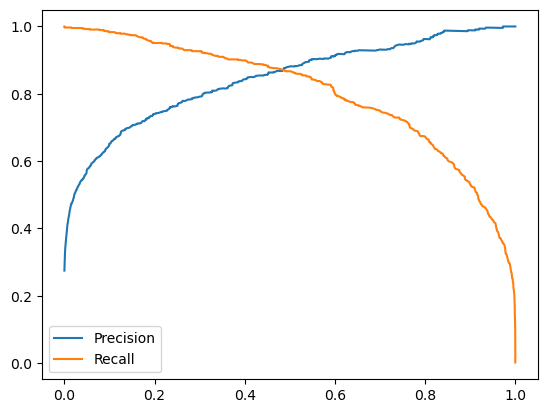

In [48]:
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.legend()

Precision and Recall curves intersect at threshold of 0.48

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52
- 0.72

In [49]:
from sklearn.metrics import f1_score

In [51]:
f1_scores = [2 * (p * r) / (p + r) if p + r > 0 else 0 for p, r in zip(precision, recall)]


In [52]:
max_f1 = max(f1_scores)
optimal_threshold = thresholds[f1_scores.index(max_f1)]
max_f1, optimal_threshold

(0.8749016522423289, 0.5457232107782676)

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

- 0.003
- 0.030
- 0.090
- 0.140

In [54]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [55]:
from tqdm.auto import tqdm

In [56]:
from sklearn.model_selection import KFold

In [64]:
df_train_full.columns

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg',
       'price', 'above_average'],
      dtype='object')

In [66]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]

    y_train = df_train.above_average
    y_val = df_val.above_average

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.979 +- 0.003


### Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [68]:
n_splits = 5

for C in tqdm([0.01, 0.1, 0.5, 10]):

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.above_average
        y_val = df_val.above_average

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.952 +- 0.002
C=0.1 0.972 +- 0.002
C=0.5 0.979 +- 0.001
C=10 0.981 +- 0.003
